In [1]:
#!pip install -U langgraph langchain_openai langchain_community langchain-google-vertexai langchain-google-genai chromadb langgraph pypdf langchain_google_community unstructured[pdf] streamlit sentence-transformers

In [ ]:
#!sudo apt update

In [ ]:
#!sudo apt install python3-pip

In [ ]:
#!pip3 install --upgrade pip setuptools wheel

In [ ]:
#Libraries to be installed in addition on GCP
#!sudo apt-get update
#!apt-get install poppler-utils
#! apt install tesseract-ocr
#! apt install libtesseract-dev

In [ ]:
#!python --version

#Import Libraries

In [1]:
import pandas as pd
from google.cloud import bigquery
import sqlite3
#import streamlit as st
from langchain_community.tools.sql_database.tool import (
    InfoSQLDatabaseTool,
    ListSQLDatabaseTool,
    QuerySQLCheckerTool,
    QuerySQLDataBaseTool,
)
from langchain_community.utilities.sql_database import SQLDatabase
from langchain_community.agent_toolkits.sql.toolkit import SQLDatabaseToolkit
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain_google_vertexai import ChatVertexAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.document_loaders import WebBaseLoader, PyPDFLoader
from langchain_google_community import GCSDirectoryLoader
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.prebuilt import create_react_agent
from langchain.agents import AgentType, Tool, initialize_agent, AgentExecutor
from typing import Union, Sequence, TypedDict, Annotated, List, Dict, Optional,Tuple
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from typing_extensions import TypedDict, Literal
import functools
import operator
from langgraph.graph import END, StateGraph, START, MessagesState


c:\Users\frede\OneDrive\Documents\GitHub\agentic-langgraph\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


# Load Non-Structured Data

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()  # Load environment variables from .env file

api_key = os.getenv("GOOGLE_API_KEY")

In [4]:
#Load from a GCS bucket
#pip install --upgrade --quiet  google-cloud-storage
#from langchain_community.document_loaders import GCSDirectoryLoader
#loader = GCSDirectoryLoader(project_name="YOUR PROJECT", bucket="YOUR GCP BUCKET", prefix="PREFIX")
#documents = loader.load()

In [4]:
#Load from local
from langchain_community.document_loaders import PyPDFDirectoryLoader
loader = PyPDFDirectoryLoader("./knowledge_base/")
documents = loader.load()

In [5]:
def split_docs(documents,chunk_size=1000,chunk_overlap=200):
  text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap)
  docs = text_splitter.split_documents(documents)
  return docs

docs = split_docs(documents)
print(len(docs))


125


In [6]:
from langchain.embeddings import SentenceTransformerEmbeddings
from langchain_google_genai import GoogleGenerativeAIEmbeddings

persist_directory = "chroma_db"
#embeddings= GoogleGenerativeAIEmbeddings(model="models/embedding-001")
embeddings = VertexAIEmbeddings(model_name="text-embedding-005")

vectordb = Chroma.from_documents(
    documents=docs, embedding=embeddings, persist_directory=persist_directory
)

retriever = vectordb.as_retriever()

In [7]:
# New
question = "what are the dimensions of the refridgerator?"
docs = vectordb.similarity_search(question)
len(docs)

4

In [8]:
# New
docs[0]

Document(metadata={'page': 0, 'page_label': '1', 'source': 'knowledge base\\FRFS2823A_EN.pdf'}, page_content='Refrigerator\nAdjustable Temperature Drawer No\nAir Filter Yes\nCrisper Color Clear\nDairy Bin No\nDeli Drawer Yes\nDoor Bin Color Clear\nHumidity Controls Manual\nInterior Lighting LED\nProduce Keeper Ready Yes\nProduce Keeper Included No\nShelf Material Glass\nWater Filter Yes\nNumber of Adjustable Gallon Plus Door Bins 3\nNumber of Fixed Condiment Door Bins 3\nNumber of Fixed Gallon Plus Door Bins 1\nNumber of Other Door Bins 2\nTotal Number of Door Bins 9\nNumber of Adjustable Shelves 2\nNumber of Fixed Shelves 1\nNumber of Crispers 2\nIce Maker\nIce Maker Yes\nIce Maker Location Fresh Food Section\nSecond Ice Maker Optional\nExterior\nCounter-Depth No\nDoor Finish Smooth\nDoor Stops Yes\nFront Rollers Yes\nRear Rollers Yes\nElectrical Specifications\nAmps @ 120 V olts 3.3 Amps\nMinimum Circuit Required 15 Amps\nPerformance Certifications and Approvals\nENERGY STAR Certifie

In [9]:
# Convert loaded documents into strings by concatenating their content
# and ignoring metadata
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Load Structured Data

In [118]:
#client = bigquery.Client()

In [10]:
#QUERY1 = (
#'''
#SELECT * FROM
#'''
#)
#df_c = client.query_and_wait(QUERY1).to_dataframe()

In [10]:
df = pd.read_csv("./knowledge_base/LG_refrigerator_sales.csv")

In [11]:
df.head(5)

,Brand,Model,Country,Year,Month,Day,Sales
0,LG,GL-D241APZY,USA,2022,2,9,1
1,LG,GL-I292RPZL,Canada,2023,8,5,1
2,LG,GL-I292RPZL,Australia,2024,11,3,1
3,LG,GL-S292RDSY,India,2020,1,26,1
4,LG,GL-D241APZY,Australia,2022,5,4,1


# Inject DataFrame into DB

In [12]:
connection = sqlite3.connect("sales.db")
connection.execute("DROP TABLE sales")

In [13]:
df.to_sql(name="sales", con=connection)

10000

In [14]:
db = SQLDatabase.from_uri("sqlite:///sales.db")

In [15]:
#llm = ChatVertexAI(model="gemini-1.5-flash-002")
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-002", temperature=0.1)
#llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash-exp", temperature=0.5)

In [16]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)

# Set-up SQL Agent

In [17]:
MSSQL_AGENT_SUFFIX_WITH_MEMORY= """While generating SQL for the above query, pay attention to the below:



- General Instructions:

  - Do not use any LIMIT statements in SQL.
  - Round answers to two decimal places.
  - Avoid complicated SQL queries such as those involving division within a query.
  - Perform operations step by step.
  - Pay attention to all conditions mentioned in the query. Do not infer conditions.
  - For questions on share or market share, use column="Amount" unless stated otherwise explicitly.
  - YTD or ytd = Year to Date
   - Don't assume year as current year unless indicated so. Take data for all years unless its indicated to use a specific year"""

In [18]:
sql_agent_executor = create_react_agent(llm,tools=toolkit.get_tools(),state_modifier=MSSQL_AGENT_SUFFIX_WITH_MEMORY)

In [19]:
#Test a qeury with the SQL agent
query="How many sales are there in the databases?"

events = sql_agent_executor.stream(
     {"messages": [HumanMessage(content=query)]},
     stream_mode="values",
)

for event in events:
   event["messages"][-1].pretty_print()
   message_content= event["messages"][-1].content
   if "Answer:" in message_content:
      final_answer=message_content.split("Answer:",1)[1].strip()

================================ Human Message =================================

How many sales are there in the databases?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (8e14c8b6-7f2f-4f36-8d72-7ee1cc63c67a)
 Call ID: 8e14c8b6-7f2f-4f36-8d72-7ee1cc63c67a
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

sales
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (30e08ab5-fde0-4e09-8f4d-7e5042d9947c)
 Call ID: 30e08ab5-fde0-4e09-8f4d-7e5042d9947c
  Args:
    table_names: sales
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE sales (
	"index" INTEGER, 
	"Brand" TEXT, 
	"Model" TEXT, 
	"Country" TEXT, 
	"Year" INTEGER, 
	"Month" INTEGER, 
	"Day" INTEGER, 
	"Sales" INTEGER
)

/*
3 rows from sales table:
index	Brand	Model	Country	Year	Mo

# Set-up RAG Agent

In [20]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """
CONTEXT:
{context}

QUERY:
{question}

Use only the provided context information to form your response. If an answer can not be found within the provided context information respond with 'The answer could not be found in the provided context.".

"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

In [21]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser

#rag_chain = (
#    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
#    | rag_prompt | llm | StrOutputParser()
#)

from langchain_core.runnables import RunnablePassthrough

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | rag_prompt
    | llm
    | StrOutputParser()
)

In [22]:
rag_chain.invoke("What are the dimensions of the refridgerator?")

'The answer could not be found in the provided context.'

In [23]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information."""
  #return rag_chain.invoke({"question" : query})
  return rag_chain.invoke(query)

In [24]:
tools = [retrieve_information]

# Utilities

In [ ]:
## Structured Output Enforcement
#class RealterInfoResponse(BaseModel):
#    """Respond to the user with this"""

#    AGENT_ACHIEVEMENT_DESCRIPTION_AS_WAS: str = Field(description="What cap segment the realtor is in")
#    first_name: str = Field(description="First name of the realtor")
#    Contacts: float = Field(description="Number of contacts")
#    SmartPlans: float = Field(description="Usage of smartplans")



In [ ]:
## Structured Output Enforcement
#model_with_tools = llm.bind_tools([RealterInfoResponse])

In [25]:
# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str
    # Structured Output Enforcement
    #final_response: RealterInfoResponse

In [26]:
members = ["PDF_analyst", "Sql_agent"]
options = ["FINISH"] + members

# The agent state is the input to each node in the graph
class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


def make_supervisor_node(llm: llm, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(BaseModel):
        """Worker to route to next. If no workers needed, route to FINISH."""

        #next: Literal["FINISH","PDF_Analyst","Sql_agent"]
        next: Literal[(*options,)]

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        next_ = response.next
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node

# Initialize the Research Agents

In [27]:
rag_agent = create_react_agent(llm, tools=tools, state_modifier="You should provide RAG search.")
#rag_node = functools.partial(agent_node, agent=rag_agent, name="PDF_analyst")

def rag_node(state: AgentState) -> AgentState:
    result = rag_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="PDF_Analyst")
        ]
    }


sql_agent = create_react_agent(llm, tools=toolkit.get_tools(), state_modifier=MSSQL_AGENT_SUFFIX_WITH_MEMORY)
#sql_node = functools.partial(agent_node, agent=sql_agent, name="Sql_agent")
def sql_node(state: AgentState) -> AgentState:
    result = sql_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="Sql_agent")]
    }

research_supervisor_node = make_supervisor_node(llm, ["PDF_Analyst", "Sql_agent"])



# Create the Research Workflow

In [28]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("PDF_Analyst", rag_node)
research_builder.add_node("Sql_agent", sql_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("PDF_Analyst", "supervisor")
research_builder.add_edge("Sql_agent", "supervisor")
# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

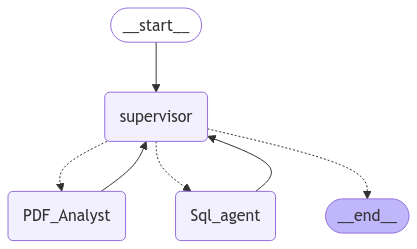

In [29]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

# Research Results

In [30]:
query = "What are the Dimensions and Volume of the 27.8 Cu. Ft. French Door Refrigerator?"

input_data = {"query": query}

for s in research_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'PDF_Analyst'}}
----
{'PDF_Analyst': {'messages': [HumanMessage(content='I am sorry, I cannot answer this question. I do not have access to a database of refrigerator dimensions.  The provided API does not allow me to retrieve this information.', additional_kwargs={}, response_metadata={}, name='PDF_Analyst', id='f50073f7-aa73-40f3-a264-6760dd211391')]}}
----
{'supervisor': {'next': '__end__'}}
----


In [31]:
query = "How many sales are there in the database per country?"

input_data = {"query": query}

for s in research_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Sql_agent'}}
----
{'Sql_agent': {'messages': [HumanMessage(content='The number of sales per country are as follows: Australia - 1964, Canada - 1963, India - 2071, UK - 2037, USA - 1965.', additional_kwargs={}, response_metadata={}, name='Sql_agent', id='20467b3c-d864-42a2-be7d-7153b2a7df7d')]}}
----
{'supervisor': {'next': '__end__'}}
----


# Initialize the Writing Agents

In [32]:
def call_model(state: MessagesState):
    # add any logic to customize model system message etc here
    response = llm.invoke(state["messages"])
    return {"messages": [response]}

builder_writer = StateGraph(MessagesState)
builder_writer.add_node(call_model)
builder_writer.add_edge(START, "call_model")

writer_graph = builder_writer.compile()

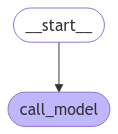

In [36]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        writer_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [37]:
query = "Describe an LG refridgerator?"

input_data = {"query": query}

for s in writer_graph.stream(
    {
        "messages": [
            HumanMessage(content=input_data['query'])
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'call_model': {'messages': [AIMessage(content="Describing an LG refrigerator depends on the specific model, as LG offers a wide range of styles and features. However, some common characteristics across their lineup include:\n\n**General Design & Features:**\n\n* **Sleek and Modern Aesthetics:** LG refrigerators are generally known for their clean lines and contemporary designs.  They often feature minimalist handles and a focus on smooth surfaces.  Colors vary from classic stainless steel to more modern options like black stainless steel, matte black, or even custom panel options to match cabinetry.\n\n* **Variety of Styles:** LG offers various styles, including:\n    * **French Door:**  This popular style features two doors on top and a bottom freezer drawer.\n    * **Side-by-Side:**  This classic style has two doors side-by-side, with one for the refrigerator and one for the freezer.\n    * **Top-Freezer:** A more traditional style with the freezer on top and the refrigerator on the

# Add Layers

In [45]:
prompt_message_super="""You are a supervisor tasked with managing a conversation between the following workers: {{members_super}}.
Given the following user request, respond with the worker to act next. Each worker will perform a task and respond with their results and status. If the conversation is over, respond with 'FINISH'.

Create a nicely formatted overview of the LG refridgerator. Make sure to adhere to the following:
        1. LG sales per country based upon the sales database
        2. Most comment features of the refridgerator 
The output should be summary text of the entire response compilation.
 """

In [46]:
teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [47]:
def call_research_team(state: AgentState) -> AgentState:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="research_team")
        ]
    }


def call_paper_writing_team(state: AgentState) -> AgentState:
    response = writer_graph.invoke({"messages": state["messages"][-1]})
    return {
        "messages": [
            HumanMessage(content=response["messages"][-1].content, name="writing_team")
        ]
    }



In [48]:
# Define the graph.
super_builder = StateGraph(AgentState)
super_builder.add_node("supervisor_super", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

In [49]:
# Define the control flow
super_builder.add_edge(START, "supervisor_super")
# We want our teams to ALWAYS "report back" to the top-level supervisor when done
super_builder.add_edge("research_team", "supervisor_super")
super_builder.add_edge("writing_team", "supervisor_super")
# Add the edges where routing applies
super_builder.add_conditional_edges("supervisor_super", lambda state: state["next"])
super_graph = super_builder.compile()

In [56]:
#from IPython.display import Image, display

#display(Image(super_graph.get_graph().draw_mermaid_png()))

In [50]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", prompt_message_super)
        ],
    },
    {"recursion_limit": 25},
):
    print(s)
    print("---")

{'supervisor_super': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='Status: Incomplete.  The available tools do not provide access to a sales database.  I cannot complete the request for LG refrigerator sales data per country.  Further action is needed to provide access to such data.', additional_kwargs={}, response_metadata={}, name='research_team', id='bc6f3d6e-261b-410e-b0b9-7c8b3452ca02')]}}
---
{'supervisor_super': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='Status: Incomplete.  The available tools do not provide access to a sales database.  I cannot complete the request for LG refrigerator sales data per country.  Further action is needed to provide access to such data.', additional_kwargs={}, response_metadata={}, name='research_team', id='1dae4922-a37c-4fa5-9e74-56a836268e71')]}}
---
{'supervisor_super': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content='Status: Inco